# Example of usage Spark OCR with Dicom Image Deidentifier

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar` and `spark-nlp-jsl-[version]`
- or `secret` for Spark OCR and `nlp_secret` for Spark NLP Internal
- `aws_access_key` and `aws_secret_key`for download pretrained models

In [1]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [2]:
import os
import sys

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
%pip install --upgrade spark-nlp-jsl==3.1.3  --extra-index-url https://pypi.johnsnowlabs.com/$nlp_secret
%pip install spark-nlp==3.1.3
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [ ]:
#%pip install --user ../../python/dist/spark-ocr-3.7.0+spark30.tar.gz

## Initialization of spark session

In [3]:
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

# if secret:
spark = start(secret=secret,
              nlp_secret=nlp_secret,
              jar_path=spark_ocr_jar_path,
              nlp_version="2.5.5",
              nlp_internal=True)

spark

SparkConf Configured, Starting to listen on port: 58253
JAR PATH:/usr/local/lib/python3.7/site-packages/sparkmonitor/listener.jar


## Import Spark OCR transformers and Spark NLP annotators

In [4]:
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import display_image

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 2.5.3
Spark NLP internal version: 2.5.3
Spark OCR version: 1.5.0


## Define de-identification  NLP pipeline

In [5]:
def deidentification_nlp_pipeline(input_column, prefix = ""):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")
    # NER model trained on i2b2 (sampled from MIMIC) dataset
    clinical_ner = NerDLModel.pretrained("ner_deid_large", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT',
                   'LOCATION', 'PROFESSION', 'PERSON', 'DATE'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline

In [6]:
# Extract images from Dicom foram
dicom_to_image = DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setDeIdentifyMetadata(True)

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])


# Found sensitive data using DeIdentificationModel
deidentification_rules = DeIdentificationModel.pretrained("deidentify_rb_no_regex", "en", "clinical/models") \
    .setInputCols(["metadata_sentence", "metadata_token","metadata_ner_chunk"]) \
    .setOutputCol("deidentified_metadata_raw")

finisher = Finisher() \
    .setInputCols(["deidentified_metadata_raw"]) \
    .setOutputCols("deidentified_metadata") \
    .setOutputAsArray(False) \
    .setValueSplitSymbol("") \
    .setAnnotationSplitSymbol("")


# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setMatchingWindow(10) \
    .setPadding(0)

# Draw filled rectangle for hide sensitive data
drawRegions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_regions")  \
    .setFilledRect(True)

# Store image back to Dicom document
imageToDicom = ImageToDicom() \
    .setInputCol("image_with_regions") \
    .setOutputCol("dicom") \
    .setInputMetadata("deidentified_metadata")

# OCR pipeline
pipeline = Pipeline(stages=[
    dicom_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text"),
    deidentification_nlp_pipeline(input_column="metadata", prefix="metadata_"),
    deidentification_rules,
    position_finder,
    drawRegions,
    finisher,
    imageToDicom
])

deidentify_rb_no_regex download started this may take some time.
Approximate size to download 8.9 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14 MB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
Approximate size to download 14 MB
[OK!]


## Read dicom objects as binary file and display metadata


### Useful Patient Identification Tags to check
 - (00100010)	PN	Patient Name
 - (00100020)	LO	Patient ID
 - (00100030)	DA	Patient's Birth Date
 - (00100040)	CS	Patient's Sexe
 - (00101010)	AS	Patient's Age
 - (00101030)	DS	Patient's Weight

None

{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.324227860973032955003270142769571823751"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.140827433504838727383120953815684045703"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.4.0rc1"
        ]
    },
    "00100010": {
        "vr": "PN",
        "Value": [
            {
                "Alphabetic": "Peter Maxime"
            }
        ]
    },
    "00100020": {
        "vr": "LO",
        "Value": [
            "MF-0000013"
        ]
    },
    "00100030": {
        "vr": "DA",
        "Value": [
            "19500704"
       

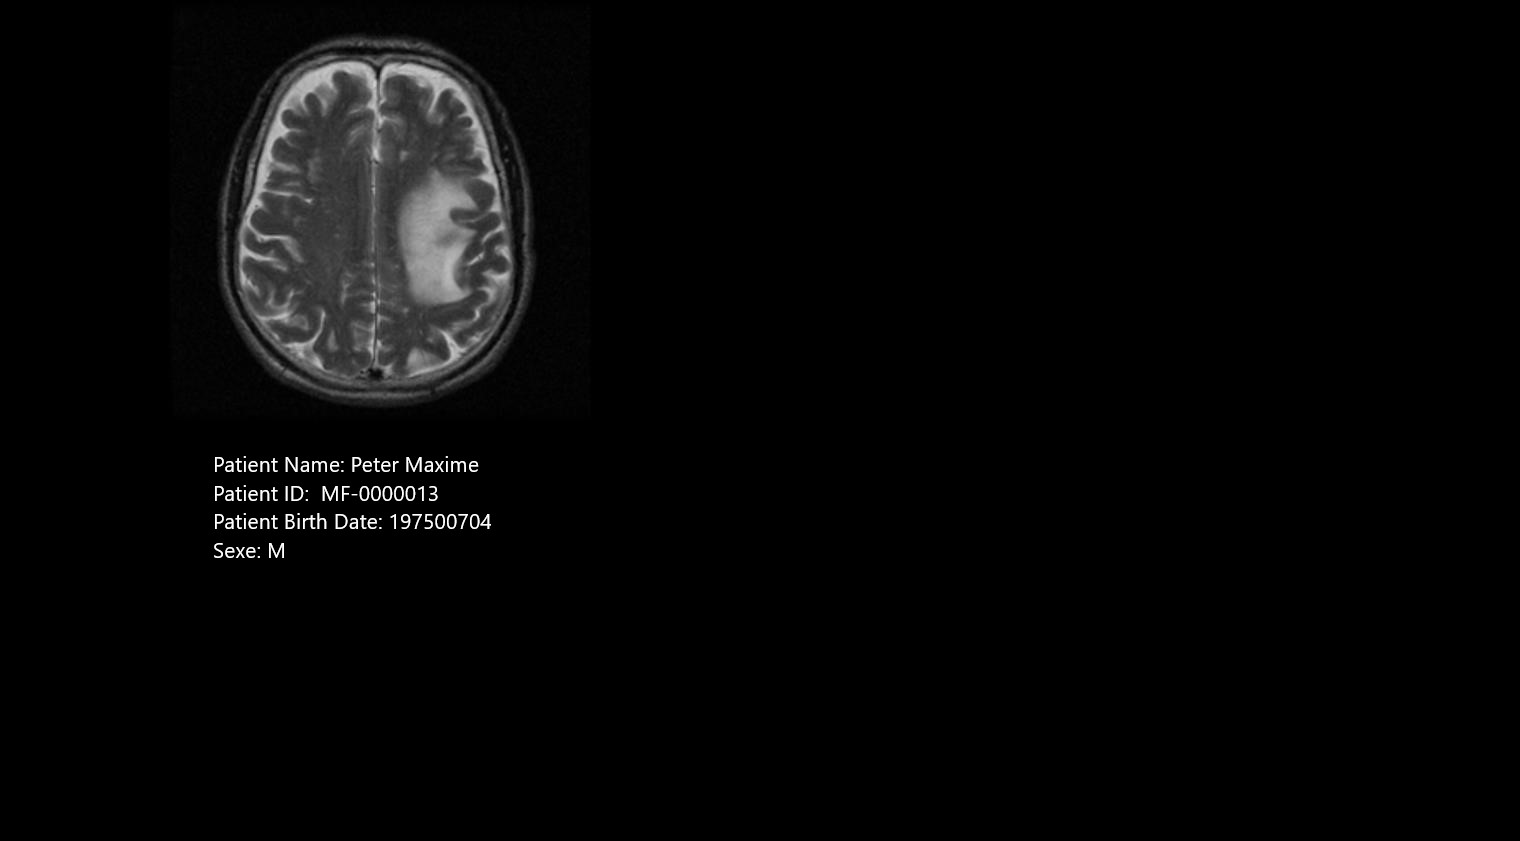

None

{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.324227860973032955003270142769571823751"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.140827433504838727383120953815684045703"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.4.0rc1"
        ]
    },
    "00100010": {
        "vr": "PN",
        "Value": [
            {
                "Alphabetic": "Peter Maxime"
            }
        ]
    },
    "00100020": {
        "vr": "LO",
        "Value": [
            "MF-0000013"
        ]
    },
    "00100030": {
        "vr": "DA",
        "Value": [
            "19500704"
       

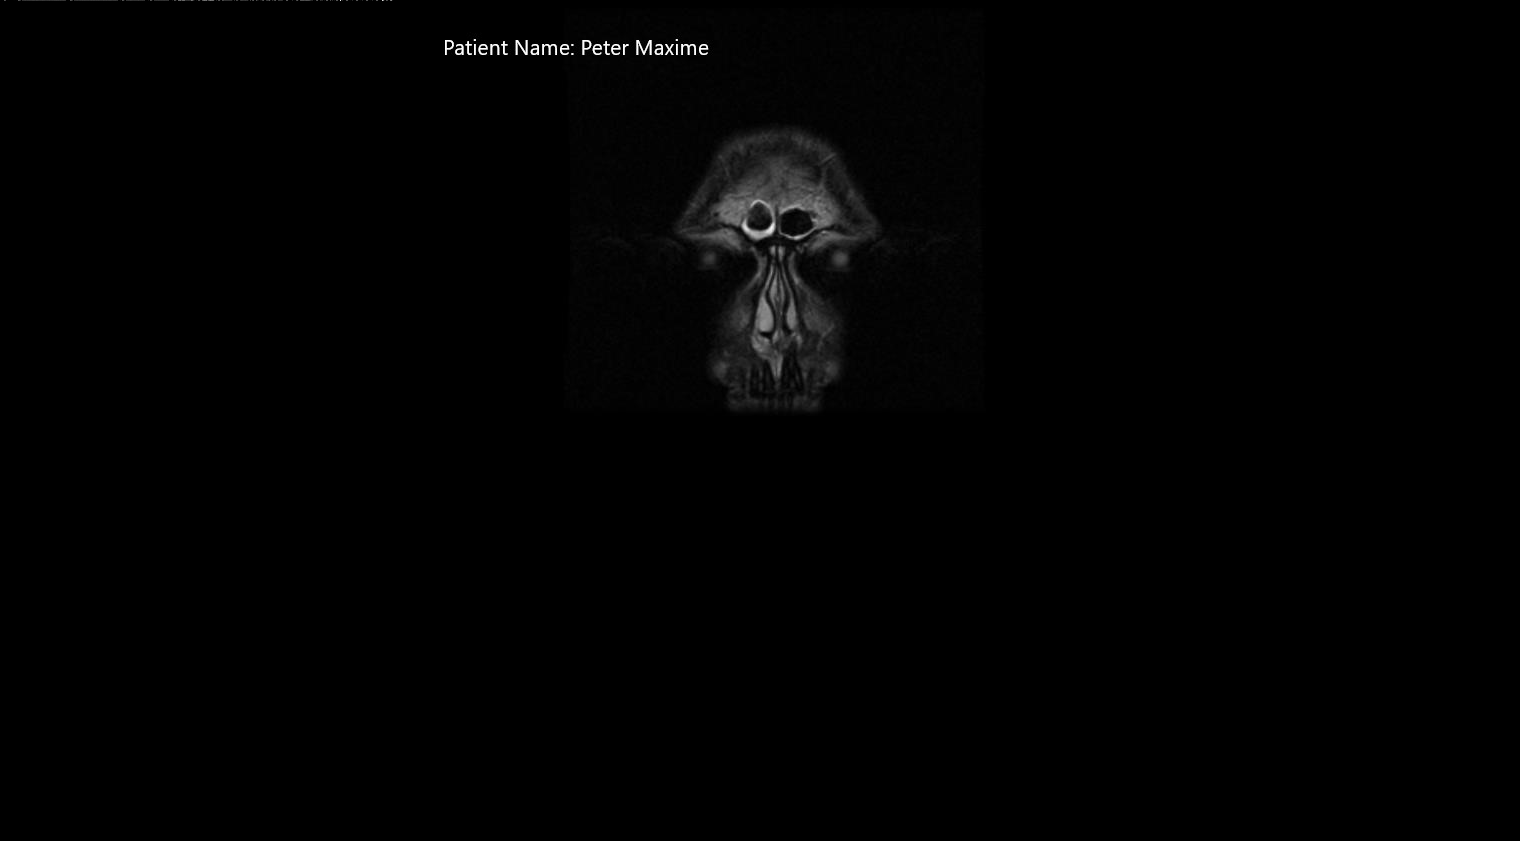

None

{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.324227860973032955003270142769571823751"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.140827433504838727383120953815684045703"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.4.0rc1"
        ]
    },
    "00100010": {
        "vr": "PN",
        "Value": [
            {
                "Alphabetic": "Peter Maxime"
            }
        ]
    },
    "00100020": {
        "vr": "LO",
        "Value": [
            "MF-0000013"
        ]
    },
    "00100030": {
        "vr": "DA",
        "Value": [
            "19500704"
       

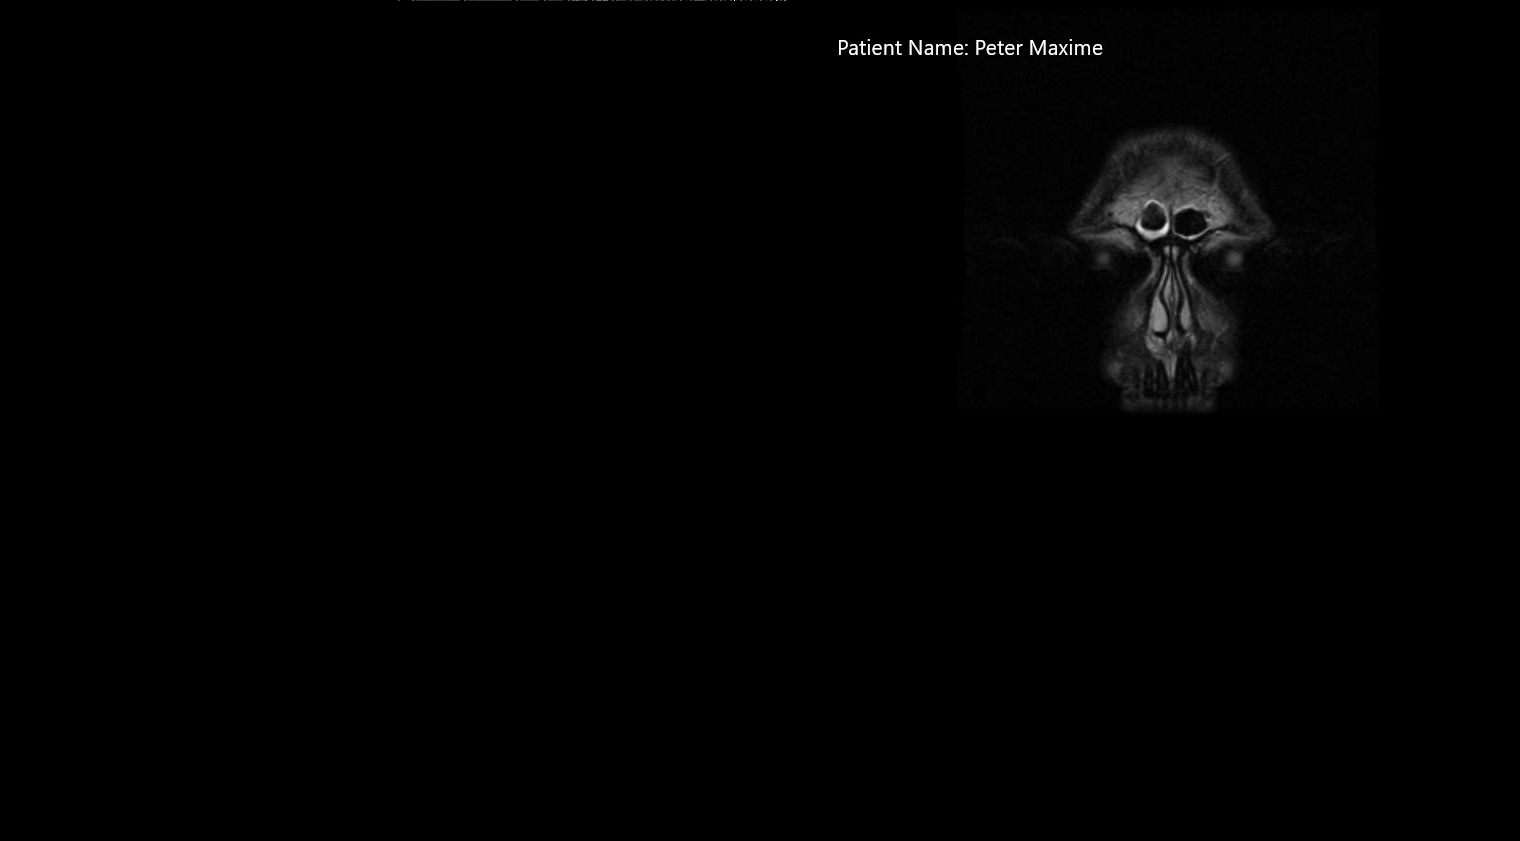

None

{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.316618858989175958452362820380094875916"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.128345240486099325554244939980269110548"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.3.6.1.4.1.30071.8"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "fo-dicom 4.0.0"
        ]
    },
    "00080020": {
        "vr": "DA",
        "Value": [
            "19990316"
        ]
    },
    "00080050": {
        "vr": "SH",
        "Value": [
            "95555556"
        ]
    },
    "00080080": {
        "vr": "LO"
    },
    "00081030": {
        "vr": "LO",
        "Value": [
            "Study Description"
    

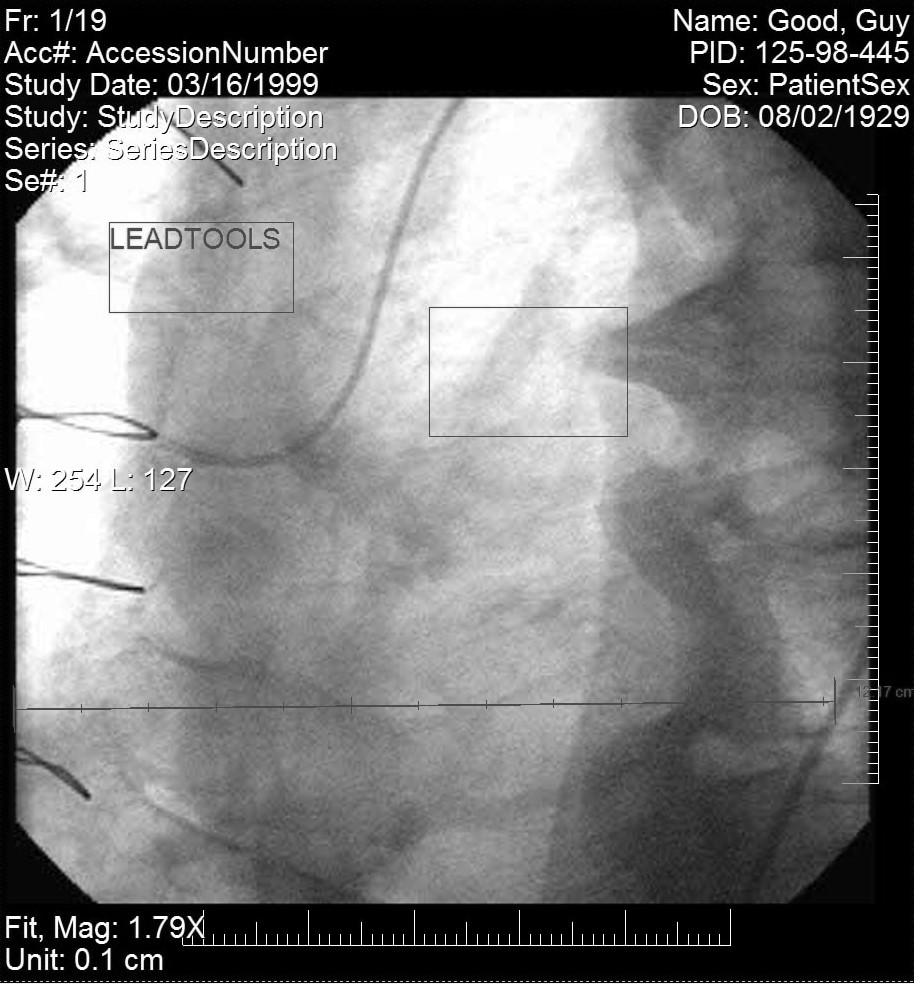

None

{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.170228217341328822848560557903560820700"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.154720347537052315951841793192285194798"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.3.6.1.4.1.30071.8"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "fo-dicom 4.0.0"
        ]
    },
    "00080020": {
        "vr": "DA",
        "Value": [
            "20180628"
        ]
    },
    "00080050": {
        "vr": "SH",
        "Value": [
            "98888333"
        ]
    },
    "00080080": {
        "vr": "LO"
    },
    "00081030": {
        "vr": "LO"
    },
    "00100010": {
        "vr": "PN",
        "Va

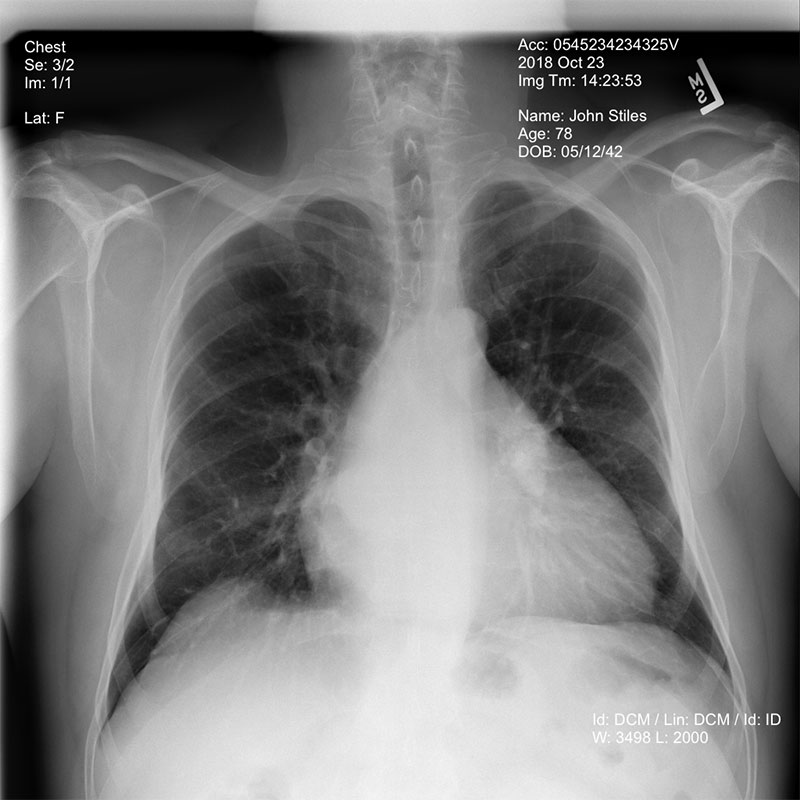

In [10]:
dicom_path = '././data/dicom/*.dcm'
dicom_df = spark.read.format("binaryFile").load(dicom_path)

# for image in DicomToImage().transform(dicom_df).collect():
#     print(image.exception)
#     print(image.metadata)
#     display_image(image.image)
   

## Run pipeline and store result

In [11]:
# NBVAL_SKIP
#dicom_to_image.setDeIdentifyMetadata(True)
de_dicom_df = pipeline.fit(dicom_df).transform(dicom_df).cache()

output_path = "././data/dicom/deidentified/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

for r in de_dicom_df.select("dicom", "path").collect():
    path, name = os.path.split(r.path)
    filename_split = os.path.splitext(name)
    file_name = os.path.join(output_path, filename_split[0]+".dcm")
    print(f"Storing to {file_name}")
    with open(file_name, "wb") as file:
        file.write(r.dicom)

Storing to ././data/dicom/deidentified/deidentify-brains-front-medical-3.dcm
Storing to ././data/dicom/deidentified/deidentify-medical-1.dcm
Storing to ././data/dicom/deidentified/deidentify-medical-2.dcm


## Display Deidentified Image and Deidentified metadata


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.169856758739667842686384595848376743359"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.190904263847748295252681483906394427197"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.5.0"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00100040": {
        "vr": "CS"
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {
  

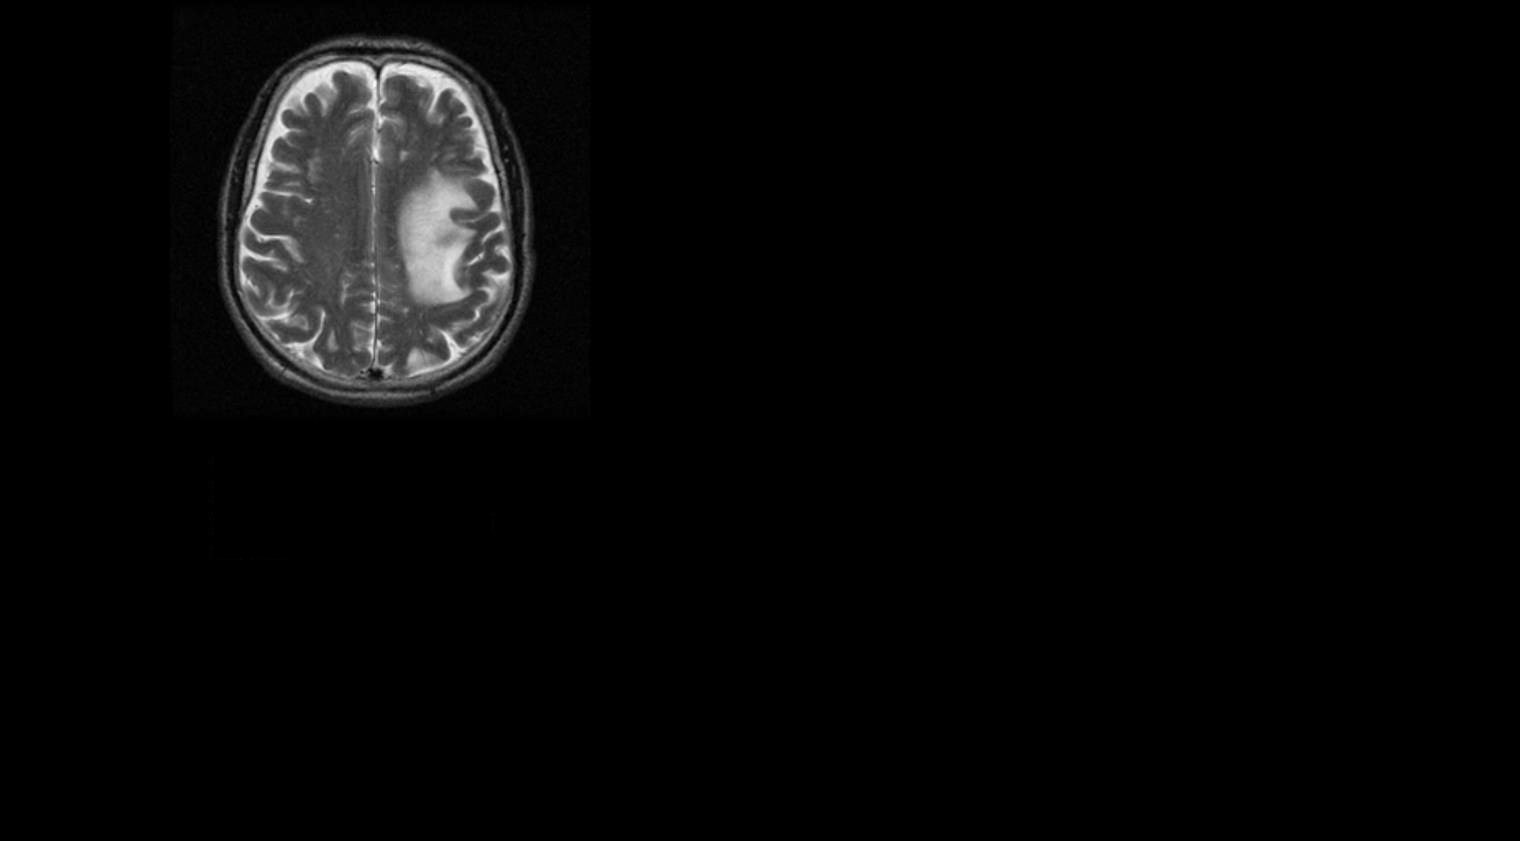


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.169856758739667842686384595848376743359"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.190904263847748295252681483906394427197"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.5.0"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00100040": {
        "vr": "CS"
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {
  

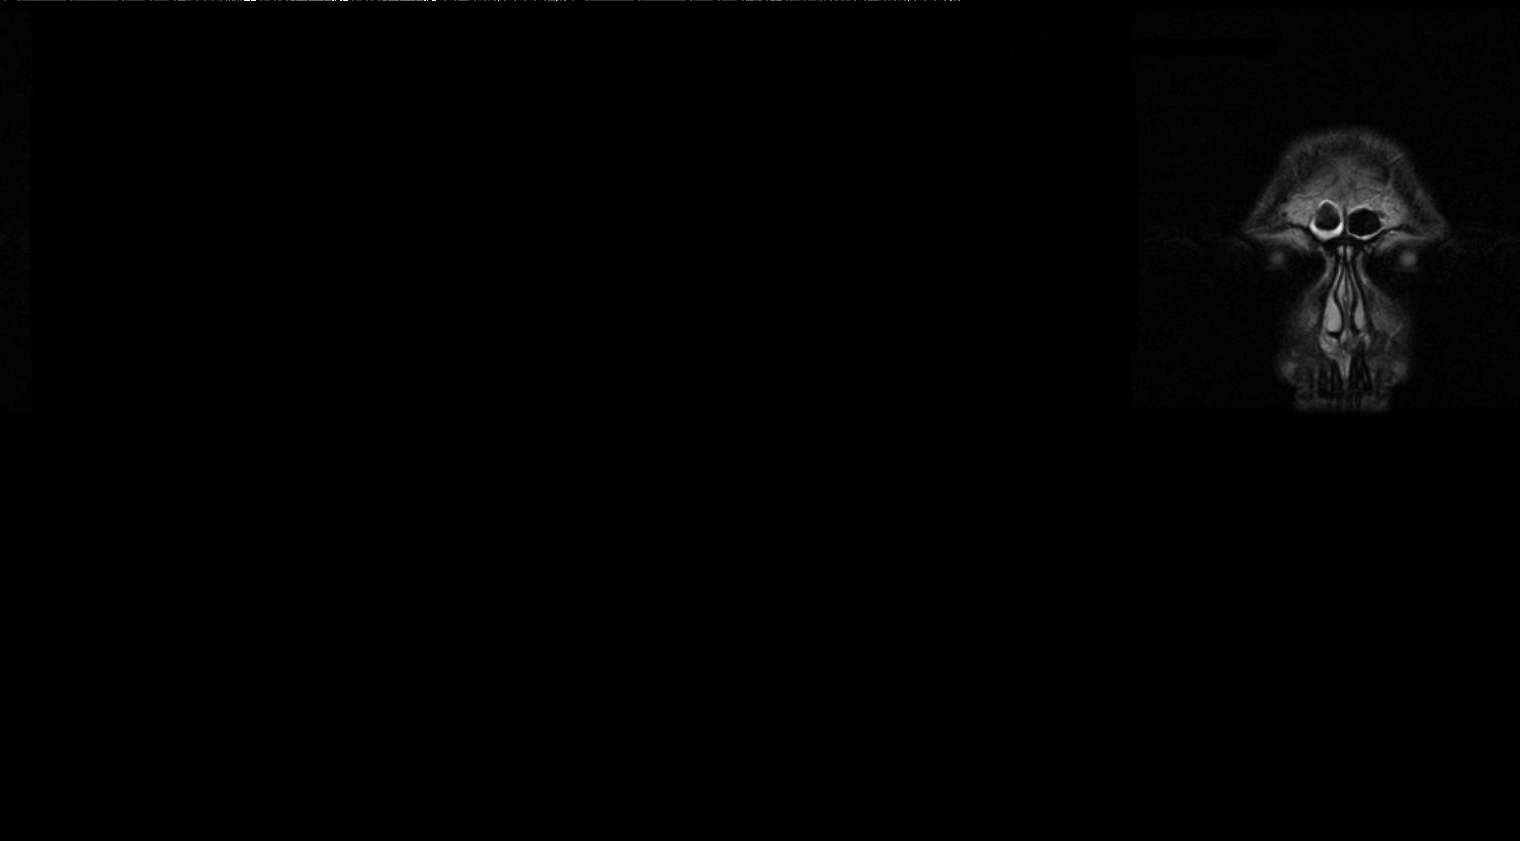


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.169856758739667842686384595848376743359"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.190904263847748295252681483906394427197"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.5.0"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00100040": {
        "vr": "CS"
    },
    "00120062": {
        "vr": "CS",
        "Value": [
            "YES"
        ]
    },
    "00120064": {
        "vr": "SQ",
        "Value": [
            {
  

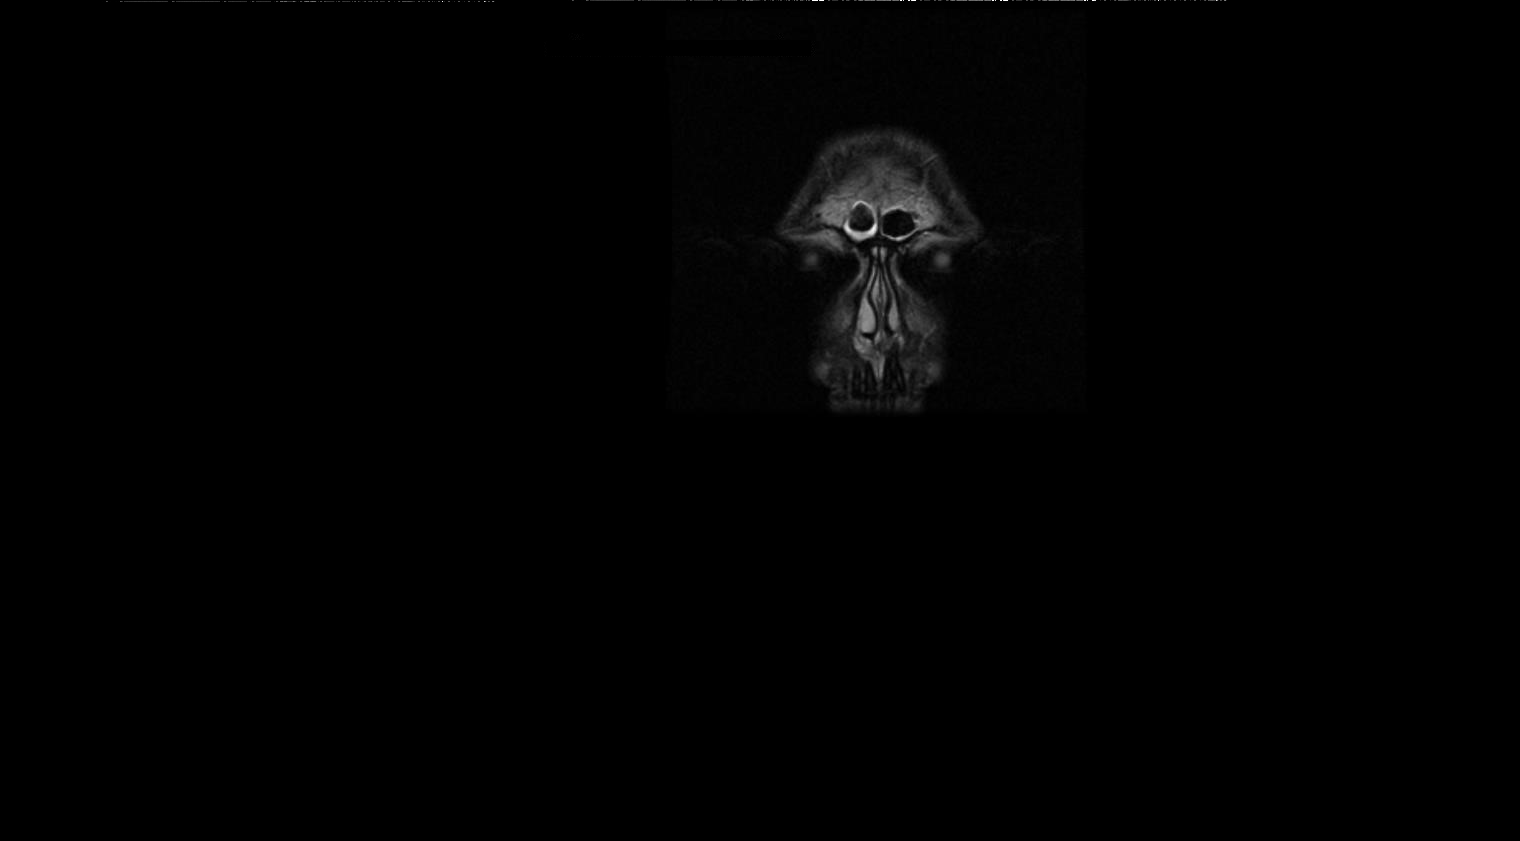


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.11947721954546794769897121412403220975"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.258028858495908755520978671460676283648"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.5.0"
        ]
    },
    "00080020": {
        "vr": "DA"
    },
    "00080050": {
        "vr": "SH"
    },
    "00080080": {
        "vr": "LO",
        "Value": [
            "REMOVED"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00100040": {
        

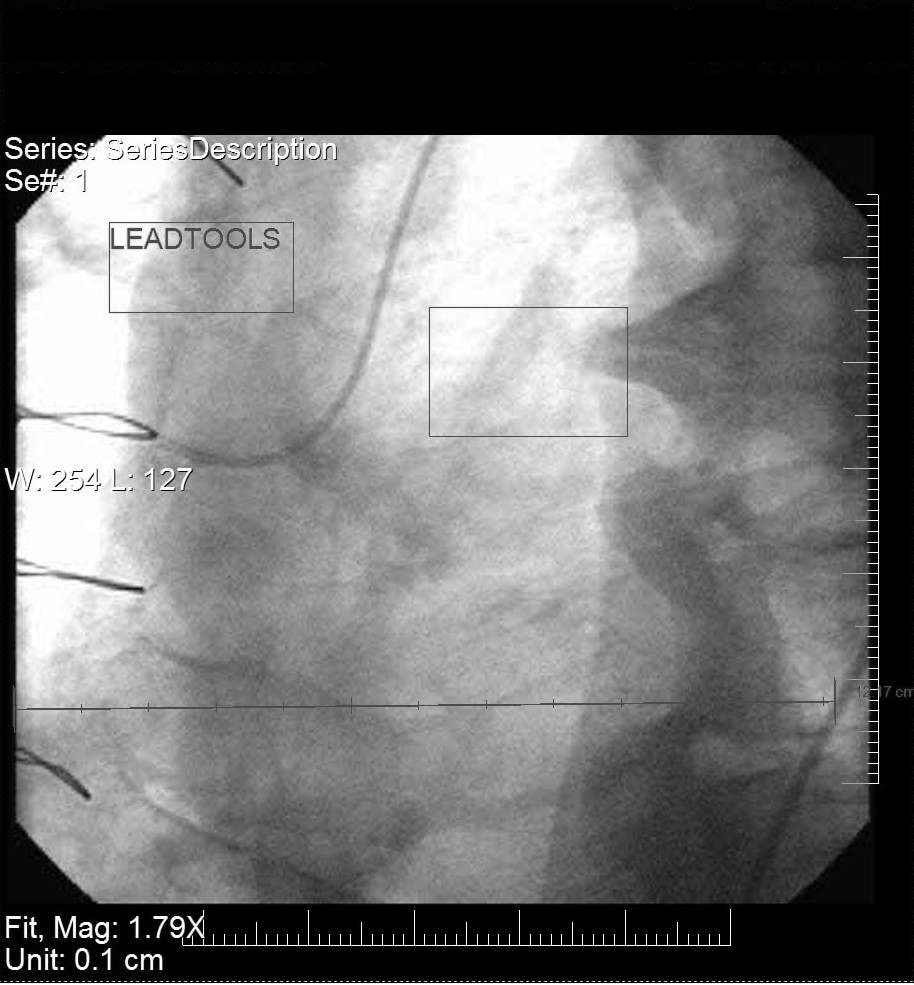


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.5244204683188422708080468717090743712"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.247289576377645189275242411157512829067"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.2.40.0.13.1.3"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "dcm4che-1.5.0"
        ]
    },
    "00080020": {
        "vr": "DA"
    },
    "00080050": {
        "vr": "SH"
    },
    "00080080": {
        "vr": "LO",
        "Value": [
            "REMOVED"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
    "00100030": {
        "vr": "DA"
    },
    "00120062": {
        "

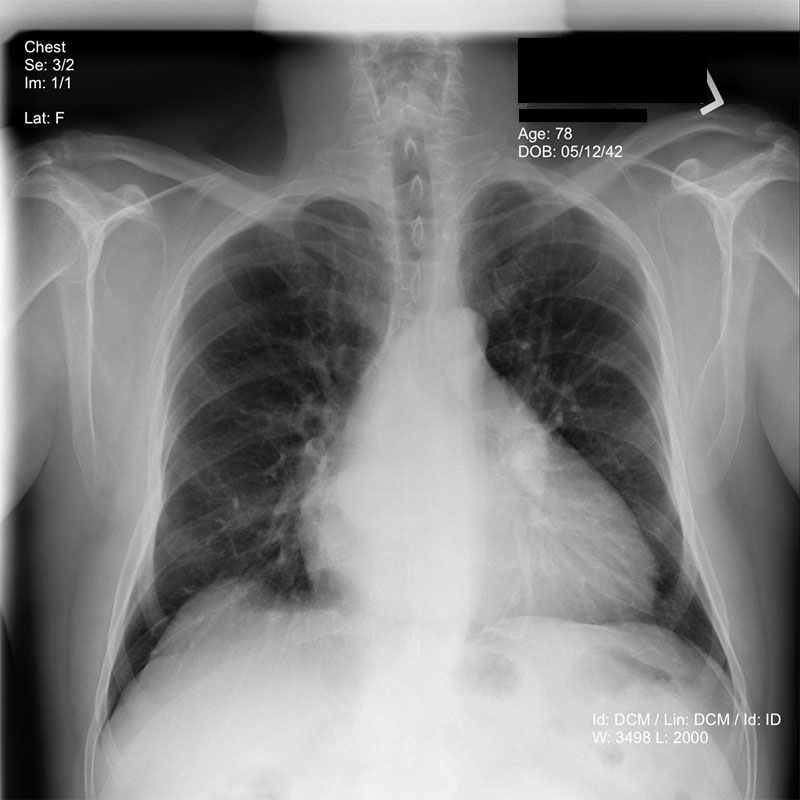

In [13]:
# NBVAL_SKIP
dicom_gen_df = spark.read.format("binaryFile").load("././data/dicom/deidentified/*.dcm")
de_dicom_gen_df = DicomToImage().transform(dicom_gen_df)
for r in de_dicom_gen_df.select("image", "metadata").collect():
    print(r.metadata)
    display_image(r.image)

## Remove reults

In [ ]:
%%bash
rm -r -f ././data/dicom/deidentified